In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

PATH = "../data/mdm2_data_files/big_table_with_weather_and_rain.csv"
df = pd.read_csv(PATH)

print(df.shape)
print(df.columns)
df.head()

(478465, 18)
Index(['ped', 'car', 'cyc', 'sensor_id', 'datetime', 'hour', 'date_only',
       'dow', 'longitude', 'latitude', 'weekday', 'month',
       'solar_altitude_deg', 'light_class', 'Dark', 'temp_c', 'wind_ms',
       'rain_mm'],
      dtype='object')


,ped,car,cyc,sensor_id,datetime,hour,date_only,dow,longitude,latitude,weekday,month,solar_altitude_deg,light_class,Dark,temp_c,wind_ms,rain_mm
0,413,381,9,1,2024-01-01 00:00:00+00:00,0,2024-01-01,0,-2.591538,51.453815,0,1,-61.529806,darkness,1,7.8,15.0,0.0
1,402,489,10,1,2024-01-01 01:00:00+00:00,1,2024-01-01,0,-2.591538,51.453815,0,1,-60.225898,darkness,1,8.0,14.0,0.0
2,421,473,10,1,2024-01-01 02:00:00+00:00,2,2024-01-01,0,-2.591538,51.453815,0,1,-54.953852,darkness,1,8.0,16.0,0.0
3,370,419,4,1,2024-01-01 03:00:00+00:00,3,2024-01-01,0,-2.591538,51.453815,0,1,-47.266506,darkness,1,7.6,14.0,0.0
4,132,123,2,1,2024-01-01 04:00:00+00:00,4,2024-01-01,0,-2.591538,51.453815,0,1,-38.404055,darkness,1,7.4,12.0,0.0


In [10]:
# Ensure datetime + time features exist
df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce", utc=True)

# If month missing, derive it 
if "month" not in df.columns:
    df["month"] = df["datetime"].dt.month

# Weekend flagging
df["is_weekend"] = df["dow"].isin([5, 6]).astype(int)

# Activity totals
df["active_all"] = df["ped"].fillna(0) + df["cyc"].fillna(0)
df["active_cyc"] = df["cyc"].fillna(0)
df["active_ped"] = df["ped"].fillna(0)

# Avoid divide by zero for ratios 
eps = 1e-6

In [11]:
# Aggregate sensor signatures
g = df.groupby("sensor_id", as_index=False)

features = g.agg(
    latitude=("latitude", "first"),
    longitude=("longitude", "first"),

    mean_all=("active_all", "mean"),
    mean_cyc=("active_cyc", "mean"),
    mean_ped=("active_ped", "mean"),

    # day vs night (Dark is 1=dark, 0=light)
    mean_dark_all=("active_all", lambda x: np.nan),  # placeholder
)

# Compute day/night means properly (needs join on df)
day_night = (df.assign(is_dark=df["Dark"].fillna(0).astype(int))
               .groupby(["sensor_id", "is_dark"], as_index=False)["active_all"]
               .mean()
               .pivot(index="sensor_id", columns="is_dark", values="active_all")
               .rename(columns={0: "mean_day_all", 1: "mean_night_all"}))

features = features.drop(columns=["mean_dark_all"]).merge(day_night, on="sensor_id", how="left")

# Weekend vs weekday means
wk = (df.groupby(["sensor_id", "is_weekend"], as_index=False)["active_all"].mean()
        .pivot(index="sensor_id", columns="is_weekend", values="active_all")
        .rename(columns={0: "mean_weekday_all", 1: "mean_weekend_all"}))

features = features.merge(wk, on="sensor_id", how="left")

# Peak hour behaviour (commuter signature)
# Define peak commuting hours (edit if you want): 7-9 and 16-18
df["is_peak"] = df["hour"].isin([7, 8, 9, 16, 17, 18]).astype(int)
pk = (df.groupby(["sensor_id", "is_peak"], as_index=False)["active_all"].mean()
        .pivot(index="sensor_id", columns="is_peak", values="active_all")
        .rename(columns={0: "mean_offpeak_all", 1: "mean_peak_all"}))

features = features.merge(pk, on="sensor_id", how="left")

# Ratios (more interpretable than raw means)
features["cyc_share"] = features["mean_cyc"] / (features["mean_all"] + eps)
features["night_share"] = features["mean_night_all"] / (features["mean_day_all"] + features["mean_night_all"] + eps)
features["weekend_ratio"] = (features["mean_weekend_all"] + eps) / (features["mean_weekday_all"] + eps)
features["peak_ratio"] = (features["mean_peak_all"] + eps) / (features["mean_offpeak_all"] + eps)

print(features.shape)
features.head()

(58, 16)


,sensor_id,latitude,longitude,mean_all,mean_cyc,mean_ped,mean_day_all,mean_night_all,mean_weekday_all,mean_weekend_all,mean_offpeak_all,mean_peak_all,cyc_share,night_share,weekend_ratio,peak_ratio
0,1,51.453815,-2.591538,673.392459,74.678952,598.713506,1004.878636,294.354210,723.855256,546.060658,546.855139,1075.836290,0.110900,0.226560,0.754378,1.967315
1,2,51.453865,-2.592004,480.398036,81.332081,399.065955,769.929773,149.332640,485.040122,468.684750,394.318406,754.168779,0.169301,0.162448,0.966280,1.912588
2,4,51.453281,-2.595743,250.104982,69.061098,181.043884,451.388548,19.894751,264.343321,214.192997,184.438496,458.986315,0.276128,0.042214,0.810283,2.488560
3,5,51.453285,-2.590382,258.501152,30.081484,228.419668,389.545806,108.692048,280.944463,201.879966,210.293433,411.798277,0.116369,0.218153,0.718576,1.958208
4,6,51.453117,-2.590430,242.302534,26.380623,215.921911,354.447374,114.099532,255.032679,210.186245,197.826905,383.731880,0.108875,0.243518,0.824154,1.939736


In [12]:
print("Longitude range:", features["longitude"].min(), "to", features["longitude"].max())
print("Latitude range :", features["latitude"].min(),  "to", features["latitude"].max())

Longitude range: -2.62552 to -2.54301
Latitude range : 51.406502 to 51.479961


In [13]:
# Drop extreme sensors by coordinates using quantiles
lon_lo, lon_hi = features["longitude"].quantile([0.05, 0.95])
lat_lo, lat_hi = features["latitude"].quantile([0.05, 0.95])

keep = (
    features["longitude"].between(lon_lo, lon_hi) &
    features["latitude"].between(lat_lo, lat_hi)
)

features_f = features[keep].copy()
features_out = features[~keep].copy()

print("Kept sensors:", len(features_f), " | Dropped sensors:", len(features_out))
print("Kept lon range:", features_f["longitude"].min(), "to", features_f["longitude"].max())
print("Kept lat range:", features_f["latitude"].min(),  "to", features_f["latitude"].max())

Kept sensors: 46  | Dropped sensors: 12
Kept lon range: -2.61689 to -2.55049
Kept lat range: 51.45005 to 51.47913


In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

XY = features_f[["longitude", "latitude"]].copy()
sc = StandardScaler()
XYz = sc.fit_transform(XY)

k = 3
km = KMeans(n_clusters=k, n_init=50, random_state=42)
features_f["cluster_geo"] = km.fit_predict(XYz)

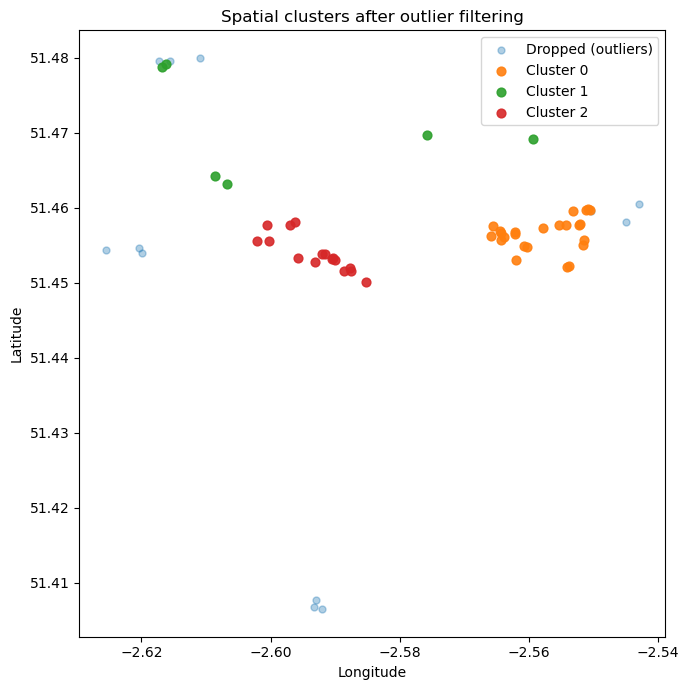

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))

# dropped (outliers) in light grey
plt.scatter(features_out["longitude"], features_out["latitude"], s=25, alpha=0.35, label="Dropped (outliers)")

# kept clusters
for c in sorted(features_f["cluster_geo"].unique()):
    sub = features_f[features_f["cluster_geo"] == c]
    plt.scatter(sub["longitude"], sub["latitude"], s=40, alpha=0.9, label=f"Cluster {c}")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Spatial clusters after outlier filtering")
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
OUT_CLUST = "../data/mdm2_data_files/sensor_clusters_geo_filtered.csv"
features_f[["sensor_id", "cluster_geo"]].to_csv(OUT_CLUST, index=False)
print("Saved:", OUT_CLUST)

Saved: ../data/mdm2_data_files/sensor_clusters_geo_filtered.csv


In [18]:
# Reload original master table
df = pd.read_csv("../data/mdm2_data_files/big_table_with_weather_and_rain.csv")

# Merge cluster labels (ONLY kept sensors)
df2 = df.merge(
    features_f[["sensor_id", "cluster_geo"]],
    on="sensor_id",
    how="inner"   # keeps only sensors inside filtered area
)

print(df2.shape)
df2.head()

(379477, 19)


,ped,car,cyc,sensor_id,datetime,hour,date_only,dow,longitude,latitude,weekday,month,solar_altitude_deg,light_class,Dark,temp_c,wind_ms,rain_mm,cluster_geo
0,413,381,9,1,2024-01-01 00:00:00+00:00,0,2024-01-01,0,-2.591538,51.453815,0,1,-61.529806,darkness,1,7.8,15.0,0.0,2
1,402,489,10,1,2024-01-01 01:00:00+00:00,1,2024-01-01,0,-2.591538,51.453815,0,1,-60.225898,darkness,1,8.0,14.0,0.0,2
2,421,473,10,1,2024-01-01 02:00:00+00:00,2,2024-01-01,0,-2.591538,51.453815,0,1,-54.953852,darkness,1,8.0,16.0,0.0,2
3,370,419,4,1,2024-01-01 03:00:00+00:00,3,2024-01-01,0,-2.591538,51.453815,0,1,-47.266506,darkness,1,7.6,14.0,0.0,2
4,132,123,2,1,2024-01-01 04:00:00+00:00,4,2024-01-01,0,-2.591538,51.453815,0,1,-38.404055,darkness,1,7.4,12.0,0.0,2


In [19]:
OUT_MASTER = "../data/mdm2_data_files/big_table_with_weather_and_rain_with_geo_clusters_v2.csv"

df2.to_csv(OUT_MASTER, index=False)

print("Saved:", OUT_MASTER)
print("Shape:", df2.shape)

Saved: ../data/mdm2_data_files/big_table_with_weather_and_rain_with_geo_clusters_v2.csv
Shape: (379477, 19)


In [20]:
df2["cluster_geo"].value_counts()

cluster_geo
0    198010
2    131967
1     49500
Name: count, dtype: int64